<a href="https://colab.research.google.com/github/kakshaycs/RecommendSystem/blob/master/RecomendedSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **A recommender system or a recommendation system (sometimes replacing "system" with a synonym such as platform or engine) is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.They are primarily used in commercial applications bold text** <br>
In this system we have a large no of user vs Song Id data where, users rated more than one song according to their preference and system will find some ralation between more than one user and more than one songs and find a abstract function that can try to predict ration for a song which are not rated by user and according to the rating we will recommend those songs to same user.that may like according to their activity of rating 

In [0]:
# Importing Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from random import uniform
import time
from random import randint

In [49]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#loading data
data=pd.read_csv("drive/My Drive/Colab Notebooks/Recommended System/songsDataset.csv")

In [51]:
data.head()

,'userID','songID','rating'
0,0,7171,5
1,0,8637,4
2,0,21966,4
3,0,35821,5
4,0,82446,5


In [52]:
# change column name
data.columns=['userID','songID','rating']
data.shape

(2000000, 3)

Text(0.5, 1.0, 'Distribution of rating')

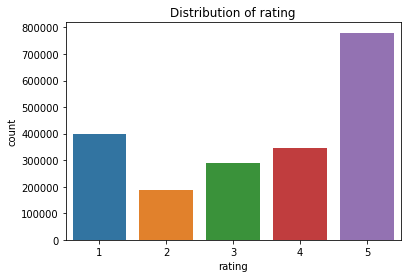

In [53]:

sns.countplot(x='rating',data = data)
plt.title('Distribution of rating')

In [72]:
# the no of user and Movie

print("Total no of User:- ",len(set(data['userID'])))
print("Total no of Songs",len(set(data['songID'])))

Total no of User:-  200000
Total no of Songs 127771


In [55]:
# this is the Rating matrix that contain column is user and rows is movies
"""    | movie1 | movie2 | movie3 
 user1  |   5    |    4   |    1
 user2  |   3    |        |    5
 user3  |   5    |    3   |    
  
"""
# the R matrix is boolean matrix that denote user rated that movie or not
print()

There are 127771 users which have rated a least one song with (0-5) rating parameter. And there are 200000 songs that is rated by the users.<br>
This system is using **Matrix factorization** technique to predict songs for particular user which haven't rated those songs.<br>
# Matrix factorization

![alt text](https://cdn-images-1.medium.com/max/1600/1*Zhm1NMlmVywn0G18w3exog.png)

###**The above image does an excellent job of summarizing, the core idea behind matrix factorization. Let there be matrix A with dimensionality of (m,n) this matrix can be viewed as a dot product between two matrix with each matrices having dimensions of (m,k) and (k,n).**

##Matrix factorization is a class of collaborative filtering algorithms used in recommender systems. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.<br>

---

If we use matrix method to store the rating so it take 127771 * 200000 <br>
Total entry is about **25554200000**.which will take about **95 GB** of RAM if we load the whole matrix at a time in RAM. Is very difficult to handle so much large data.
So, there are several aternative to take of these problem<br>

1.   Read in a chunk
2. Process the chunk
3. Save the results of the chunk
4. Repeat steps 1 to 3 until we have all chunk results
5. Combine the chunk results

But as a good knowledge of Alorithm and datastructure we will take care which out using any type of chunk. we store the matrix in Dictionary. Because, given matrix is sparse matrix and we need to handle only 2000000 of user and songs combination so Dictionary will play a important role.

In [74]:
Rating = dict()
for i in range(2000000):
  Rating[(data['userID'][i],data['songID'][i])] = data['rating'][i]
  if i%100000==0:
    clear_output(wait=True)
    print("complete :- ",i/(20000))

complete :-  95.0


We don't know about the features of different songs and what type of songs a user like and dislike. We have only rating by a users <br>
Lets sppose ***user 1*** give 5 start to ***song x*** and <br>
 ***user 2*** also give 5 star to ***song x***<br>,so by only two rating we can conclude that somehow ***user 1*** and ***user 2*** have similar interest.<br>
 And if ***user 1*** rated a ***song y*** to 4 star, So there is large probability that ***user 2*** will also rated ***song y*** to 4 
 

---

So that we assume some features of songs, on the basis of that features a user will predict its rating.<br>
Only asigning features for a song will not help much but we have also some parameters that for a user too.<br>
Both the feature of the songs and parameters of a user can solve our problem.<br>
And one more things both the parameter and the feature are same in numbers but may different in values.<br>
We assigning 5 features for songs and 5 parameters for a user and set a small random value for both features and parameters

example:-           

1.   melody
2.   romance
3. Rock
4. pop
5. classic

***We will assign a random value for each categories in User And Songs Features***


---


Total no of User is 200000 and Songs is 127771 <br> 
So we create two matrix    USER (200000  ,  5) and Song  (127771, 5)

In [0]:
def randomR():
  return round(randint(0,100)/randint(100,200),3)

**Assigning Random variable to the features and parameters**

In [0]:
USERS = np.array([[randomR() for i in range(5)] for i in range(200002)])
SONGS = np.array([[randomR() for i in range(5)] for i in range(127773)])

***OUR GOAL***

We need to find dot product of the features and parameters of a user and a songs to find approximate rating, and accoring to the error we got, we will modify the both features and parameters .<br>
We will repeat this step until the error will minimize<br>
After the minimization of error we got some specific value in features and parameters. And that help to predict the unrated songs.

In [0]:
# Indexing for each USERS and SONGS
User=list(set(data['userID']))
Song=list(set(data['songID']))
U=dict()
S=dict()
for i in range(len(User)):
    U[User[i]]=i
for i in range(len(Song)):
    S[Song[i]]=i


In [0]:
# set parameters and learning rate
alpha = 0.05
lamda = 0.1
E=[]

In [94]:
#learning with collaborating Filtering
for itr in range(20):
    error=0
    for x in Rating:
        i=U[x[0]]
        j=S[x[1]]
        d=sum(USERS[i,:] * SONGS[j,:]) -Rating[x]
        error+=abs(d)
        USERS[i,:] =  USERS[i,:] - alpha * (  d * SONGS[j,:] + lamda * USERS[i,:] )
        SONGS[j,:] = SONGS[j,:] - alpha * (  d * USERS[i,:] + lamda * SONGS[j,:] )
    E.append(round(error/2000000,4))
    print("Iteration = ",itr,"Error = ",E[itr])

  

Iteration =  0 Error =  0.9898
Iteration =  1 Error =  0.9541
Iteration =  2 Error =  0.9029
Iteration =  3 Error =  0.8579
Iteration =  4 Error =  0.8214
Iteration =  5 Error =  0.7917
Iteration =  6 Error =  0.7671
Iteration =  7 Error =  0.7464
Iteration =  8 Error =  0.7288
Iteration =  9 Error =  0.7137
Iteration =  10 Error =  0.7007
Iteration =  11 Error =  0.6893
Iteration =  12 Error =  0.6793
Iteration =  13 Error =  0.6705
Iteration =  14 Error =  0.6626
Iteration =  15 Error =  0.6557
Iteration =  16 Error =  0.6494
Iteration =  17 Error =  0.6438
Iteration =  18 Error =  0.6387
Iteration =  19 Error =  0.634


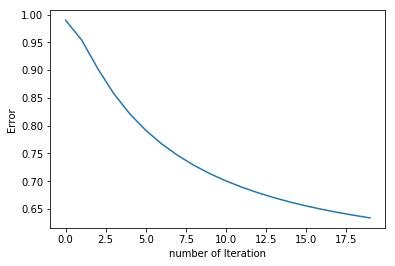

In [96]:
plt.plot(range(20),E)
plt.xlabel("number of Iteration")
plt.ylabel("Error")
plt.show()

In [67]:
USERS[127771,:]

array([0.32294215, 0.60242845, 0.55836286, 0.5404673 , 0.40399469])

## rough work

In [0]:
USERS[1,:]*SONGS[1,:]

In [0]:
A=dict()
A['akshay']=1
A['kumar']=2
A['singh']=3

In [0]:
A=[1,2,3,2,3,4,5,4,3,4,5,6,7]
d={x:i for }

In [0]:
for i in A:
    print(i)

In [0]:
 127771 * 200000 *4

In [0]:
102216800000/(2**30)

In [0]:
2**10

In [0]:
plt.plot([1,1.2,1.3,1.38,1.39,2,4,8,10])
plt.show()